In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-07-02 19:48:36


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf

from   invisible_cities.reco.params           import S12Params 
from   invisible_cities.reco.params           import CalibVectors
from   invisible_cities.reco.params           import DeconvParams
from   invisible_cities.reco.params           import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.core.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12


In [4]:
import invisible_cities.icaro.mpl_functions as mpl

In [5]:
import invisible_cities.reco.event_model as evm
from invisible_cities.core.ic_types import minmax

In [5]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound

In [6]:
run_number = 4446
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [7]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [8]:
from invisible_cities.reco.dst_functions  import load_dst

In [13]:
event=0

In [10]:
filename = '/Users/jjgomezcadenas/Projects/ICDATA/LSC/wvfms/4446/dst_waves.gdcsnext.999_4446.root.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 52000
nsipm: 1792
sipmwl: 1300



### Reconstruction Parameters

In [11]:
calib_vectors = CalibVectors(channel_id = DataPMT.ChannelID.values,
                             coeff_blr = abs(DataPMT.coeff_blr   .values),
                             coeff_c = abs(DataPMT.coeff_c   .values),
                             adc_to_pes = DataPMT.adc_to_pes.values,
                             adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                             pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist())


deconv_params = DeconvParams(n_baseline = 48000,
                              thr_trigger = 5)

s1par = S12Params(time = minmax(min    = 0 * units.mus,
                           max    = 649 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin  = False)

s2par = S12Params(time = minmax(min    = 650 * units.mus,
                           max    = 1299 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin  = True)

thresholds = ThresholdParams(thr_s1=0.2 * units.pes,
                      thr_s2=0.5 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=3.5*units.pes,
                      thr_SIPM=10*units.pes)



#### Using method compute_csum_and_pmaps defined in reco/peak_functions.py

In [22]:
event=0
t0 = time.time()
csum, pmp = pf.compute_csum_and_pmaps(event, pmtrwf, sipmrwf, s1par, s2par, thresholds,
                        calib_vectors, deconv_params)
t1 = time.time()
dt = t1 - t0
print("compute_csum_and_pmaps in  = {} s".format(dt))

compute_csum_and_pmaps in  = 0.4557952880859375 s


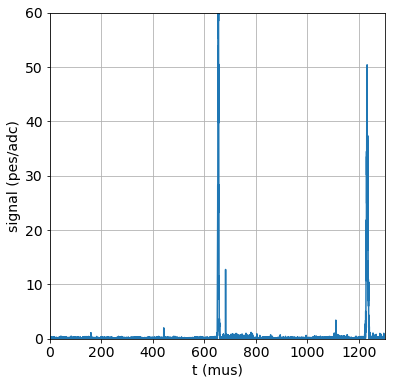

In [24]:
mpl.plot_signal_vs_time_mus(csum.csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    0,
                        signal_max =  60,
                        figsize=(6,6))

#### Raw S1 dictionary

In [25]:
pmp.S1

{0: [array([ 40925.,  40950.,  40975.,  41000.]),
  <MemoryView of 'ndarray' at 0x118b9ba38>],
 1: [array([ 135450.,  135475.,  135500.,  135525.]),
  <MemoryView of 'ndarray' at 0x118b9bbe0>],
 2: [array([ 140675.,  140700.,  140725.,  140750.]),
  <MemoryView of 'ndarray' at 0x118b9bd88>],
 3: [array([ 158975.,  159000.,  159025.,  159050.,  159075.,  159100.]),
  <MemoryView of 'ndarray' at 0x118b9b048>],
 4: [array([ 161400.,  161425.,  161450.,  161475.]),
  <MemoryView of 'ndarray' at 0x118b9c1f0>],
 5: [array([ 181700.,  181725.,  181750.,  181775.]),
  <MemoryView of 'ndarray' at 0x118b9c398>],
 6: [array([ 441775.,  441800.,  441825.,  441850.,  441875.,  441900.,
          441925.,  441950.,  441975.,  442000.,  442025.,  442050.,
          442075.,  442100.,  442125.,  442150.]),
  <MemoryView of 'ndarray' at 0x118b9c540>],
 7: [array([ 480800.,  480825.,  480850.,  480875.]),
  <MemoryView of 'ndarray' at 0x118b9c6e8>],
 8: [array([ 647750.,  647775.,  647800.,  647825.]),


#### Instance of S1 class

In [26]:
s1 = evm.S1(pmp.S1)

In [27]:
s1

S1(number of peaks = 10)
peak number = 0: Waveform(samples = 4 width = 0.1 mus , energy = 1.6 pes
        height = 0.5 pes tmin-tmax = minmax(min=40.9, max=41.0) mus  
peak number = 1: Waveform(samples = 4 width = 0.1 mus , energy = 1.4 pes
        height = 0.4 pes tmin-tmax = minmax(min=135.4, max=135.5) mus  
peak number = 2: Waveform(samples = 4 width = 0.1 mus , energy = 1.5 pes
        height = 0.4 pes tmin-tmax = minmax(min=140.7, max=140.8) mus  
peak number = 3: Waveform(samples = 6 width = 0.1 mus , energy = 4.2 pes
        height = 1.1 pes tmin-tmax = minmax(min=159.0, max=159.1) mus  
peak number = 4: Waveform(samples = 4 width = 0.1 mus , energy = 1.3 pes
        height = 0.5 pes tmin-tmax = minmax(min=161.4, max=161.5) mus  
peak number = 5: Waveform(samples = 4 width = 0.1 mus , energy = 1.0 pes
        height = 0.4 pes tmin-tmax = minmax(min=181.7, max=181.8) mus  
peak number = 6: Waveform(samples = 16 width = 0.4 mus , energy = 17.9 pes
        height = 2.0 pes tmin-tm

In [32]:
s1.number_of_peaks

1

In [33]:
s1.peak_waveform(0)

Waveform(samples = 7 width = 0.1 mus , energy = 9.0 pes
        height = 2.0 pes tmin-tmax = minmax(min=100.1, max=100.2) mus 

In [34]:
try:
    s1.peak_waveform(2)
except PeakNotFound:
    pass
    

In [35]:
s1.peak_waveform(0).t

array([ 100075.,  100100.,  100125.,  100150.,  100175.,  100200.,  100225.])

In [36]:
s1.peak_waveform(0).E

array([ 1.29416144,  1.99560936,  1.88525513,  1.412292  ,  0.73227114,
        0.90618465,  0.76593857])

#### Instance of s2 class

In [37]:
s2 = evm.S2(pmp.S2)

In [38]:
s2

S2(number of peaks = 1)
peak number = 0: Waveform(samples = 13 width = 11.4 mus , energy = 6236.7 pes
        height = 1204.9 pes tmin-tmax = minmax(min=619.0, max=630.4) mus  

In [39]:
s2.number_of_peaks

1

In [41]:
s2.peak_waveform(0)

Waveform(samples = 13 width = 11.4 mus , energy = 6236.7 pes
        height = 1204.9 pes tmin-tmax = minmax(min=619.0, max=630.4) mus 

In [42]:
try:
    s2.peak_waveform(5)
except PeakNotFound:
    pass

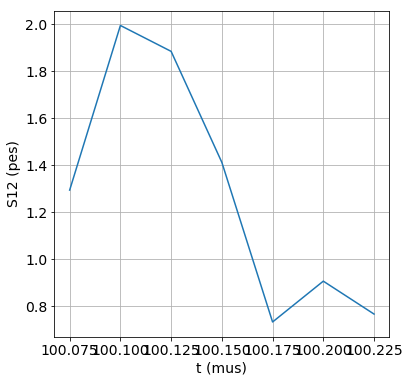

In [43]:
plot_s12(s1)

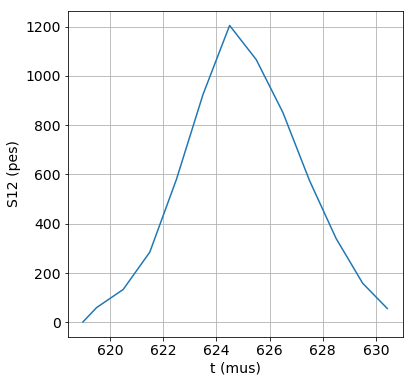

In [44]:
plot_s12(s2)

#### Raw S2Si

In [45]:
pmp.S2Si

{0: {1517: array([  0.        ,   0.        ,   0.        ,   7.88852887,
           8.88858887,  10.02199021,  12.22212222,  11.02205021,
           0.        ,   4.02163019,   0.        ,   0.        ,   0.        ]),
  1518: array([  0.        ,   0.        ,   0.        ,   8.8937031 ,
          11.89283526,   7.93653326,   6.02219358,   0.        ,
          12.91381643,   0.        ,   0.        ,   0.        ,   0.        ]),
  1525: array([  0.        ,   0.        ,   0.        ,   0.        ,
          11.89251702,  11.89251702,  16.0274716 ,  13.83077698,
          11.11721304,   6.98225846,   0.        ,   0.        ,   0.        ]),
  1526: array([  0.        ,   0.        ,   0.        ,  10.99067659,
           5.01358236,  12.08326371,  19.92418302,  10.02662913,
           7.96999456,   5.97762981,   3.98526507,   0.        ,   0.        ]),
  1534: array([  0.        ,   0.        ,   0.        ,   0.        ,
           8.02370644,   6.93375518,  10.74858458,   5.904

#### Instance of class S2Si

In [46]:
s2si = evm.S2Si(pmp.S2, pmp.S2Si)

In [47]:
s2si

S2Si(number of peaks = 1)
peak number = 0: Waveform(samples = 13 width = 11.4 mus , energy = 6236.7 pes
        height = 1204.9 pes tmin-tmax = minmax(min=619.0, max=630.4) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1517, 1518, 1525, 1526, 1534)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1517
    sipm waveform (zs) = Waveform(samples = 6 width = 6.0 mus , energy = 54.1 pes
        height = 12.2 pes tmin-tmax = minmax(min=621.5, max=627.5) mus 
peak number = 0: sipm number = 1518
    sipm waveform (zs) = Waveform(samples = 5 width = 5.0 mus , energy = 47.7 pes
        height = 12.9 pes tmin-tmax = minmax(min=621.5, max=626.5) mus 
peak number = 0: sipm number = 1525
    sipm waveform (zs) = Waveform(samples = 6 width = 5.0 mus , energy = 71.7 pes
        height = 16.0 pes tmin-tmax = minmax(min=622.

In [48]:
s2si.number_of_peaks

1

In [50]:
s2si.number_of_sipms_in_peak(0)

5

In [51]:
try:
    s2si.sipms_in_peak(5)
except PeakNotFound:
    pass


In [52]:
s2si.peak_waveform(0).E

array([    1.22686353,    59.54449255,   133.04172218,   284.60687433,
         579.571922  ,   924.59716426,  1204.89787344,  1066.38161954,
         852.14752782,   575.96013119,   340.50972049,   158.42505477,
          55.83360781])

In [53]:
s2si.peak_waveform(0).t

array([ 618987.5,  619500. ,  620500. ,  621500. ,  622500. ,  623500. ,
        624500. ,  625500. ,  626500. ,  627500. ,  628500. ,  629500. ,
        630425. ])

In [54]:
s2si.sipms_in_peak(0)

(1517, 1518, 1525, 1526, 1534)

In [55]:
try:
    s2si.sipms_in_peak(5)
except PeakNotFound:
    pass



In [56]:
s2si.sipm_waveform(0,1517)

Waveform(samples = 13 width = 11.4 mus , energy = 54.1 pes
        height = 12.2 pes tmin-tmax = minmax(min=619.0, max=630.4) mus 

In [57]:
s2si.sipm_waveform(0,1517).E

array([  0.        ,   0.        ,   0.        ,   7.88852887,
         8.88858887,  10.02199021,  12.22212222,  11.02205021,
         0.        ,   4.02163019,   0.        ,   0.        ,   0.        ])

In [58]:
s2si.sipm_waveform_zs(0,1517)

Waveform(samples = 6 width = 6.0 mus , energy = 54.1 pes
        height = 12.2 pes tmin-tmax = minmax(min=621.5, max=627.5) mus 

In [59]:
s2si.sipm_waveform_zs(0,1517).t/units.mus

array([ 621.5,  622.5,  623.5,  624.5,  625.5,  627.5])

In [60]:
s2si.sipm_waveform_zs(0,1517).E

array([  7.88852887,   8.88858887,  10.02199021,  12.22212222,
        11.02205021,   4.02163019])

In [61]:
try:
    s2si.sipm_waveform_zs(4,1)
except SipmNotFound:
    pass

KeyError: 4

In [62]:
try:
    s2si.sipm_waveform_zs(0,1)
except SipmEmptyList:
    print("sipm empty list")

SipmNotFound: 